In [1]:
from google.colab import drive
drive.mount('./gdrive/')

Mounted at ./gdrive/


In [2]:
from PIL import Image
import os
import cv2
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import validation_curve
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import KFold
import sys

In [ ]:
from pathlib import Path
import pandas as pd

In [ ]:
!pip install transformers
from transformers import  ViTForImageClassification

# !pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 27.2 MB/s 
     |████████████████████████████████| 6.6 MB 56.4 MB/s 
     |████████████████████████████████| 120 kB 74.7 MB/s 


In [ ]:
!pip install timm
import timm
from pprint import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 28.5 MB/s 


In [ ]:
# !unzip './gdrive/My Drive/Pest Detection/competition/train.zip' -d './gdrive/My Drive/Pest Detection/wheat rust/variant'


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [ ]:
!dir ./gdrive/MyDrive/Pest\ Detection/wheat\ rust/dataset

dir: cannot access './gdrive/MyDrive/Pest Detection/wheat rust/dataset': No such file or directory


In [3]:
DATADIR = './gdrive/MyDrive/DeepLearning/pests/overfit'
SYSPATH = './gdrive/MyDrive/DeepLearning/Classifier'

In [4]:
sys.path.append(SYSPATH)

In [5]:
from MyClassifier import Classifier, EarlyStopper

In [ ]:
# Load training data
# define batch and image size
# dataset transformations and augmentation

batch_size = 4
image_size = 224
Datatransforms = transforms.Compose([transforms.Resize(image_size),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ])                                                  

train_data = datasets.ImageFolder(DATADIR + '/train', transform=Datatransforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['XR_ELBOW_negative', 'XR_ELBOW_positive', 'XR_FINGER_negative']


In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 23
    Root location: ./gdrive/MyDrive/Thesis/sMURA-v1.1/smallDataset/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [ ]:
inputs, classes = next(iter(trainloader))
inputs.shape, classes.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

In [ ]:
classes.to(device)

tensor([0, 1, 0, 0], device='cuda:0')

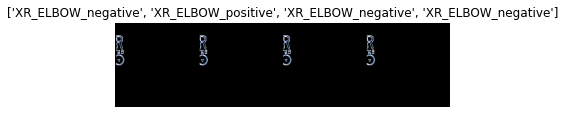

In [ ]:

show_databatch(inputs, classes)

In [ ]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_t

In [ ]:
class MyModel(torch.nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()

        google_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

        for param in google_model.parameters():
          param.requires_grad = False

        num_features = google_model.classifier.in_features
        newClassifierLayers = [nn.Linear(num_features, 512) , nn.Tanh() ]
        newClassifierLayers.extend([nn.Linear(512, len(class_names))])
        newClassifierLayers
        google_model.classifier = nn.Sequential(*newClassifierLayers)
        self.google_model = google_model

        timm_model = timm.create_model('vit_large_r50_s32_224_in21k', pretrained=True)

        for param in timm_model.parameters():
          param.requires_grad = False

        num_features = timm_model.head.in_features
        newClassifierLayers = [nn.Linear(num_features, 512) , nn.Tanh() ]
        newClassifierLayers.extend([nn.Linear(512, len(class_names))])
        newClassifierLayers
        timm_model.head = nn.Sequential(*newClassifierLayers)
        self.timm_model = timm_model

    def forward(self, x):
        p = self.google_model(x)
        p = p.logits
        q = self.timm_model(x)
        
        return (p+q)/2

In [ ]:
model = MyModel()

In [ ]:
model

MyModel(
  (timm_model): VisionTransformer(
    (patch_embed): HybridEmbed(
      (backbone): ResNetV2(
        (stem): Sequential(
          (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
          (norm): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
        )
        (stages): Sequential(
          (0): ResNetStage(
            (blocks): Sequential(
              (0): Bottleneck(
                (downsample): DownsampleConv(
                  (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (norm): GroupNormAct(
                    32, 256, eps=1e-05, affine=True
                    (drop): Identity()
                    (act): Identity()
                  )
                )
                (conv1): St

In [ ]:
# define model architecture topology ect
# model's hyper params like learning rate and momentum
# loss criterion and optimizer
# model name to save model's state on disk

model_name = 'google_and_timm'

learning_rate = 0.001
momentum = 0.7
def create_model():
  model = MyModel()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  return model, criterion, optimizer

In [ ]:
model, criterion, optimizer = create_model()

In [ ]:
model(inputs)

tensor([[-0.3748,  0.0492],
        [-0.3180,  0.4942],
        [ 0.2067,  0.4085],
        [-0.1936,  0.2281]], grad_fn=<AddmmBackward0>)

In [ ]:
# load model from disk if it's already saved
# model.load_state_dict(torch.load(DATADIR+'/'+model_name+'.pth'))

In [ ]:
classifier = Classifier(train_data, class_names, create_model, DATADIR+"/"+model_name+'.pth')

In [ ]:
# Early stopping with KFold cross validation
early_stopping = EarlyStopper(2, 0.1)
valid_losses = classifier.kfold(10, 5, batch_size, None)  #(epochs, ? , _ , early_stopping)

fold:0 ======================================
Epoch: 0; Training Loss: 0.7243053592102868; Running Accuracy: 0.5787671232876712; Time Taken: 103.32270956039429
validation loss: 0.5248399966142394, validation accuracy: 0.8409090909090909
Epoch: 1; Training Loss: 0.42336960664817264; Running Accuracy: 0.7077625570776256; Time Taken: 105.59633922576904
validation loss: 0.41164860569617967, validation accuracy: 0.8806818181818182
Epoch: 2; Training Loss: 0.3101960534283093; Running Accuracy: 0.7374429223744292; Time Taken: 105.70041632652283
validation loss: 0.3857660510323264, validation accuracy: 0.8693181818181818
Epoch: 3; Training Loss: 0.24730721939887318; Running Accuracy: 0.7511415525114156; Time Taken: 106.00595235824585
validation loss: 0.31876374362036586, validation accuracy: 0.9147727272727273
Epoch: 4; Training Loss: 0.19949501653867108; Running Accuracy: 0.7625570776255708; Time Taken: 105.37163949012756
validation loss: 0.2928704016587951, validation accuracy: 0.90909090909

In [ ]:
# Experiment the classifier with train validation split and optional early stopping
early_stopping = EarlyStopper(2, 0.15)
losses = classifier.experiments(10, 0.2, batch_size, None)

Epoch: 0; Training Loss: 1.1950837969779968; Running Accuracy: 0.3888888888888889; Time Taken: 0.5002095699310303
validation loss: 1.2387637197971344, validation accuracy: 0.2
Epoch: 1; Training Loss: 1.1336274027824402; Running Accuracy: 0.5555555555555556; Time Taken: 0.4785332679748535
validation loss: 1.1610392928123474, validation accuracy: 0.2
Epoch: 2; Training Loss: 1.146437692642212; Running Accuracy: 0.16666666666666666; Time Taken: 0.49182891845703125
validation loss: 1.7830167412757874, validation accuracy: 0.2
Epoch: 3; Training Loss: 1.0261420130729675; Running Accuracy: 0.5555555555555556; Time Taken: 0.5968911647796631
validation loss: 1.6814042329788208, validation accuracy: 0.2
Epoch: 4; Training Loss: 1.0586309790611268; Running Accuracy: 0.5555555555555556; Time Taken: 0.5024387836456299
validation loss: 1.5204434394836426, validation accuracy: 0.2
Epoch: 5; Training Loss: 1.0412484884262085; Running Accuracy: 0.5555555555555556; Time Taken: 0.4580502510070801
valid

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
count = 0
losses_sum = 0
for fold, losses in validation_losses.items():
  avg_loss = sum(losses)/len(losses)
  losses_sum += avg_loss
  count+=1

losses_sum/count

0.3072259949890643

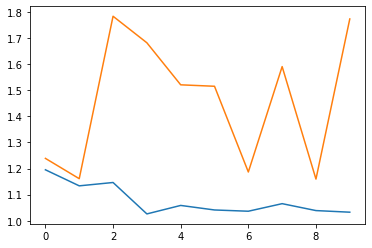

In [ ]:
plt.plot(losses['train'])
plt.plot(losses['valid'])

In [ ]:
# Train model for final deployment or getting results on real test data
model = train(4, model_name)

Epoch: 0; Training Loss: 0.7268747985363007; Running Accuracy: 0.375; Time Taken: 17.2438223361969
Epoch: 1; Training Loss: 0.7018822729587555; Running Accuracy: 0.5; Time Taken: 19.104748487472534
Epoch: 2; Training Loss: 0.621985673904419; Running Accuracy: 0.875; Time Taken: 17.665613174438477
Epoch: 3; Training Loss: 0.5902166813611984; Running Accuracy: 0.8125; Time Taken: 16.846441984176636


In [ ]:
# Function to load test data that contains only test images
def load_test_data(data_dir):
    path = data_dir
    images = []
    names = []
    for img in os.listdir(path):
        try:
            img_arr = Image.open(os.path.join(path, img), )
            resized_arr = img_arr.resize((image_size, image_size))
            images.append(resized_arr)
            names.append(img)
        except Exception as e:
            print(e)
    return np.array(images), names

In [ ]:
# Load actual test data from directory that contains unlabled test images
test_images, names = load_test_data(DATADIR+'/test')

cannot identify image file './gdrive/My Drive/DeepLearning/animal-classifier/test/.DS_Store'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# Prepare transformations for test images
transformations = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

# Initialize variables for accuracy calculations
results = []
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for image, fname in zip(test_images, names):

        # Transform image to computable tensor
        image = transformations(image)
        image.unsqueeze_(0)
        image.to(device)

        # Get the output of the model
        outputs = model(image)
        
        # Calculate class probabilities and output class
        probabilities = nn.Softmax(dim=-1)(outputs).detach().cpu().numpy()
        output_probabilities = probabilities[0]
        output_class = np.argmax(output_probabilities)

        # Prepare array for results on test images
        results.append( [fname, output_class])

# Create and save csv for final results
results = np.array(results)
cols = ['ID', 'label']
df = pd.DataFrame(results, columns=cols)

df.to_csv(DATADIR+'/output.csv', index=False)

Streaming output truncated to the last 5000 lines.
[[9.997980e-01 2.020572e-04]]
[[0.996924   0.00307596]]
[[0.9874549  0.01254507]]
[[0.9962843  0.00371571]]
[[0.99650687 0.00349307]]
[[0.93200535 0.06799471]]
[[0.90869087 0.09130909]]
[[0.961475   0.03852495]]
[[0.8797196  0.12028034]]
[[0.99575776 0.00424228]]
[[0.7916683  0.20833176]]
[[0.99127614 0.00872385]]
[[0.9857654  0.01423462]]
[[0.31444067 0.68555933]]
[[0.99620664 0.00379339]]
[[0.7059871  0.29401284]]
[[0.9018245  0.09817552]]
[[0.9405667  0.05943326]]
[[0.9878605  0.01213949]]
[[0.96992725 0.03007277]]
[[0.99875295 0.00124705]]
[[0.48600277 0.51399726]]
[[0.98626757 0.01373246]]
[[0.98922616 0.01077389]]
[[0.93604076 0.06395927]]
[[0.13440318 0.86559683]]
[[0.6111288 0.3888712]]
[[0.9318988  0.06810122]]
[[0.966693   0.03330698]]
[[0.99686605 0.0031339 ]]
[[0.6571417  0.34285828]]
[[9.992638e-01 7.362071e-04]]
[[0.9929517  0.00704826]]
[[0.94579965 0.05420034]]
[[0.98646426 0.01353578]]
[[0.9958003  0.00419972]]
[[0.767

In [ ]:
df.head()

,ID,label
0,ASG001bqwg_2.jpeg,0
1,ASG001g2rm_2.jpeg,0
2,ASG001f5n2_2.jpeg,0
3,ASG001g7sb_2.jpeg,0
4,ASG001dr9n_2.jpeg,0


In [ ]:
#use vision transformers